In [309]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

<ipython-input-310-de66bb0fd666>:2: DeprecationWarning: This function is deprecated. Please call randint(0, 60000 + 1) instead
  start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]


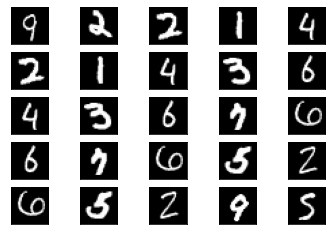

In [310]:
side = 5
start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]
fig, ax = plt.subplots(side, side)
for a in range(side):
    for b in range(side):
        ax[a, b].axes.xaxis.set_visible(False)
        ax[a, b].axes.yaxis.set_visible(False)
        ax[a, b].imshow(x_train[2 * a + b + start, :, :], cmap='gray')
plt.show()

In [311]:
print("x_train:", x_train.shape)
x_train = x_train.reshape(x_train.shape[0], -1).T
print("x_train flatten:", x_train.shape)
print("y_train:", y_train.shape)
y_train = y_train.reshape(y_train.shape[0],1).T
print("y_train:", y_train.shape)

x_train: (60000, 28, 28)
x_train flatten: (784, 60000)
y_train: (60000,)
y_train: (1, 60000)


## Code

## Import

In [312]:
import numpy as np

## Normalization

In [313]:
x_train = x_train/255
x_test = x_test/255

## initialize_parameters

In [314]:
def initialize_parameters(layers_dims):
    parameters = {}
    L = len(layers_dims) - 1
        
    for l in range(1, L+1):
        parameters['W'+str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2./layers_dims[l-1])
        parameters['b'+str(l)] = np.ones((layers_dims[l], 1))
    
    return parameters

## activation_funtion

In [315]:
def activation_funtion(Z, activation):
    if activation == "relu":
        A = np.maximum(np.zeros(1), Z)
        print("activation:", activation)
        return A
        
    if activation == "sigmoid":
        A = 1 / (1 + np.exp(-Z))
        print("activation:", activation)
        return A
    
    print("activation: linear")
    return Z

## forward_propagation

In [316]:
def forward_propagation(X, parameters, activation):
    cache = {}
    L = len(parameters)// 2
    cache['A0'] = X
    
    for l in range(1,L):
        cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
        cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])
    l += 1
    
    cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
    
    cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])
    
    return cache

## compute_cost

In [317]:
def compute_cost(AL,Y, loss):
    m = Y.shape[1]
    
    AL = AL.T
    if loss == "cross_entropy":
        epsilon = 1e-10
        cost = -(1/m) * np.sum(np.multiply(np.log(AL + epsilon), Y) + np.multiply(np.log(1-AL + epsilon), 1-Y))
        return np.squeeze(cost)
        

## back_propagation

In [318]:
layers_dims = [x_train_flatten.shape[0],32,16,10]
activation = ["relu","relu","sigmoid"]
loss_funtion = "cross_entropy"

print(y_train.shape)

parameters = initialize_parameters(layers_dims)

cache = forward_propagation(x_train_flatten, parameters, activation)

cost = compute_cost(cache['A' + str(len(layers_dims)-1)].T, y_train, loss_funtion)

print("cost:",cost)

(1, 60000)
activation: relu
activation: relu
activation: sigmoid
cost: 1518.7175239861672


In [319]:
layers_dims = [5,5,2,4]
activation = ["relu","relu","sigmoid"]
loss_funtion = "cross_entropy"

X = np.random.randn(layers_dims[0],1) * 10
Y = np.array([[0, 0, 1, 1]])

parameters = initialize_parameters(layers_dims)

cache = forward_propagation(X, parameters, activation)

print("Y:", Y.shape)
print("Y:", Y)
print("X:", X.shape)
print("X:", X)
print("Z3:", cache['Z' + str(len(layers_dims)-1)].shape)
print("Z3:", cache['Z' + str(len(layers_dims)-1)])
print("A3:", cache['A' + str(len(layers_dims)-1)].shape)
print("A3:", cache['A' + str(len(layers_dims)-1)])


cost = compute_cost(cache['A' + str(len(layers_dims)-1)].T, Y, loss_funtion)

print("cost:",cost)

activation: relu
activation: relu
activation: sigmoid
Y: (1, 4)
Y: [[0 0 1 1]]
X: (5, 1)
X: [[ -9.60015717]
 [-14.76531806]
 [  1.79525961]
 [ -0.38534043]
 [ -2.84910681]]
Z3: (4, 1)
Z3: [[1.]
 [1.]
 [1.]
 [1.]]
A3: (4, 1)
A3: [[0.73105858]
 [0.73105858]
 [0.73105858]
 [0.73105858]]
cost: 3.253046749055659
